In [129]:
import numpy as np
import matplotlib.pyplot as plt

This notebook analyzes the algorithms from Chapter 1 in *Probability and Computing* (Mitzenmacher & Upfal). The motivation for analyzing these algorithms is better comprehend probability theory. What I find interesting is that these examples analyze deterministic algorithms with probabilistic ones. The main motivation for using probability is the tradeoff between speed and *correctness*.

### Polynomial Checking
Given two polynomials $F(x)$ and $G(x)$, our objective is to create a probabilistic algorithm to check $F(x) \equiv G(x)$, assuming that $x \exists \mathbb{Z}$, and the degrees of $F(x)$ and $G(x)$ have the same degree. We treat the two polynomials as a black box, as we are focused on the analysis.

In this example, we draw $r$ uniformly from $\{1, 2, ... , 100d\}$, where $d$ is the degree of $F(x)$ and $G(x)$. We sample $r$ with replacement.<br>
If $F(r) = G(r)$, the algorithm concludes that $F(x)=G(x)$. If $F(r) \ne G(r)$, the algorithm concludes that $F(x) \ne G(x)$. This algorithm has a one-sided error; when $h(x)=F(r)-G(r)=0$ and $r$ is a root of $h(x)$, the algorithm determines that $F(r)=G(r)$ even though $F(x) \ne G(x)$ can occur. In this scenario, we are interested in the probability of the algorithm failing.

Becasue there are at most $d$ roots,<br>
$$
P(\text{Algorithm Fails}) \le \frac{d}{100d} = \frac{1}{100} = 0.01
$$

In [130]:
# polynomial degree
DEGREE = 3

def F(x):
    return 2 * (x-1) * (x-2) * (x-3)

def G(x):
    return (x**3) - 6*(x**2) + 11*x - 6

Polynomial descriptions:<br>
$$
F(x) = 2\prod_{k=1}^{3}(x-k)=2(x-1)(x-2)(x-3)
$$
$$
G(x) = x^{3}-6x^{2}+11x-6
$$

Without fully factoring $F(x)$, $F(x) \ne G(x)$, because $F(x)=2G(x)$.

In [ ]:
def polynomial_check(N, d, B):
    # Random uniform sample
    r = np.random.randint(1, (N*d)+1, size=B)
    eq = (F(r) == G(r))

    return sum(eq)

In [132]:
B = 100_000 # Number of simulations
N = 100   # Maximum range of random sample

# Tracks number of F(r)=G(r) events
eq = polynomial_check(N, DEGREE, B)

p_failure = 100 * (eq / B)
print(f"Estimated P(alg. fails) = {round(p_failure, 6)}%")

Estimated P(alg. fails) = 0.964%


As we can see, the estimated $P(\text{Algorithm Fails})$ is close to the theoretical value of 1%. We estimated the probability by running a monte carlo simulation and tracking the events $F(r)=G(r)$. We track equivalency because as stated above, $F(x) \ne G(x)$.

To check the distribution of $P(\text{Algorithm Fails})$, we will run the simulation (above) many times.

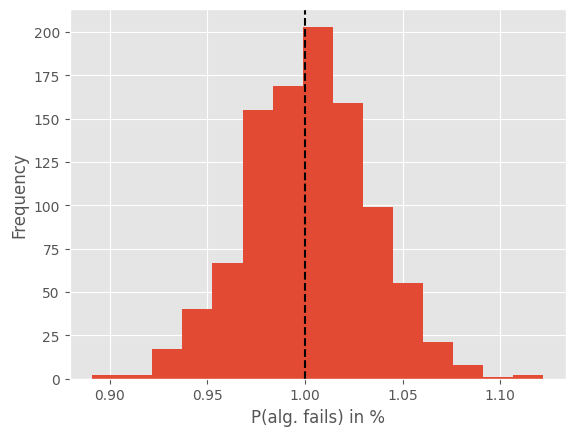

In [133]:
N_REPS = 1000
p_failures = [0] * N_REPS

for i in range(N_REPS):
    # Tracks number of F(r)=G(r) events
    eq = polynomial_check(N, DEGREE, B)

    p_fail = 100 * (eq / B)
    p_failures[i] = p_fail

# Histogram of simulations
plt.style.use("ggplot")
plt.hist(p_failures, bins=15)
plt.axvline(x=(100 * (1/100)), color="black", linestyle="--")
plt.xlabel("P(alg. fails) in %")
plt.ylabel("Frequency")
plt.show()

The distribution of $P(\text{Algorithm Fails})$ is nicely centered around the theoretical value of 1%.

### Matrix Multiplication Validation

Suppose we have three matrices A, B, and C. We want to determine if the following idenity is true:
$$
AB=C
$$

Similarl to the polynomial checking algorithm, we will use randomness to validate the equality. The algorithm generates a random vector $r$ defined as, $r=(r_1,r_2,...,r_n) \exists \{0,1\}^{n}$. Again, we sample with replacement.
We then compute $ABr$ and $Cr$. If $ABr=Cr$, the algorithm concludes that $AB=C$. If $ABr \ne C$, then the algorithm concludes that $AB \ne C$. When $AB \ne C$, there is a chance the algorithm returns $AB=C$.

The proof of the following statement can be found on page 10 of *Probability and Computing* (Mitzenmacher, Upfal).
$$
P(ABr=Cr) \le \frac{1}{2} = 0.5
$$

In [148]:
A = [
    [1, 0, 1, 1, 0],
    [0, 0, 1, 0, 1],
    [1, 1, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 0, 1]
]

B = [
    [0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 1, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 1, 1, 1]
]

In [ ]:
def matrix_multiplication(A, B):
    """
    NOTE: Assumes dimensions of A and B are valid.
    There are better optimized matrix multiplication algorithms,
    but I write this explicitly.
    """

    a_r, b_r = len(A), len(B)
    a_c, b_c = len(A[0]), len(B[0])

    C = [[0 for _ in range(b_c)] for _ in range(a_r)]

    for a_row in range(a_r):
        for b_col in range(b_c):
            for r in range(a_c):
                C[a_row][b_col] += A[a_row][r] * B[r][b_col]

    return C

def vector_multiplication(A, v):
    """
    NOTE: Assumes dimensions of A and v are correct.
    """

    v_prime = [0 for _ in range(len(v))]

    for i in range(len(A)):
        for j in range(len(v)):
            v_prime[i] += v[j] * A[i][j]

    return v_prime

# Compute the CORRECT product of A and B
C = matrix_multiplication(A, B)

We start by explicity computing the product matrix $C$. Later, we will corrupt the matrix to make the equality $AB=C$ invalid.

In [150]:
def matrix_mult_check(A, B, C, trials=1):
    """
    NOTE: Assumes the dimensions of A, B, and C are
    valid.
    """

    # Checks the identity AB=C
    #          Rows    Cols
    a_r, a_c = len(A), len(A[0])
    b_r, b_c = len(B), len(B[0])
    c_r, c_c = len(C), len(C[0])

    eq = 0

    for _ in range(trials):
        # Generate random vector {0,1}
        r = np.random.randint(0, 2, size=b_c)

        b_prime = vector_multiplication(B, r)
        a_prime = vector_multiplication(A, b_prime)
        c_prime = vector_multiplication(C, r)

        # Check a_prime = c_prime
        eq += np.array_equal(a_prime, c_prime)

    return eq

In [151]:
T = 1000 # Number of simulations

eq = matrix_mult_check(A, B, C, trials=T)

p_failure = (1 - (eq / T)) * 100
print(f"Estimated P(alg. fails) = {round(p_failure, 6)}%")

Estimated P(alg. fails) = 0.0%


Because $C$ was explicitly computed, we know that $AB=C$ and the algorithm will always return the correct result. This probabilistic check has a one-sided error.

We are interested in the case when $AB \ne C$. In the section below, one element of the product matrix is corrupted such that $AB \ne C$.

In [152]:
C_corrupt = C.copy()
C_corrupt[0][0] += 1

eq = matrix_mult_check(A, B, C_corrupt, trials=T)

p_failure = (1 - (eq / T)) * 100
print(f"Estimated P(alg. fails) = {round(p_failure, 6)}%")

Estimated P(alg. fails) = 51.4%


The estimated $P(\text{Algorithm Fails})$ is close to the theoretical probability of 50%. By itself, this algorithm seems useless if it fails 50% of the time, on average. Its strength comes from running it multiple times.

Stated above, $r$ is drawn randomly with replacement. Suppose we repeat the process $k$ times.
$$
P(\text{Algorithm Fails}) = \frac{1}{2^k}
$$

In [ ]:
k = 5